### Example - Time between earthquakes

Suppose that earthquakes of a certain magnitude in a specific region can be modeled as a Poisson process with a mean of $\lambda = 4.5$ earthquakes per day.  Let $X$ be the time until the third earth quake.  It can be shown that $X$ has a $Gamma$ distribution with $\alpha = 3$ (number of events) and $\beta = \frac{1}{\lambda}=\frac{1}{4.5}$ (average time until the 3rd earthquake).  We can use Python's `random.gammavariate` to simulate the distribution.

In [ ]:
%pip install composable

Note: you may need to restart the kernel to use updated packages.


In [20]:
import polars as pl
import numpy as np
from composable import pipeable
from random import gammavariate
from functools import reduce

take = pipeable(lambda n, seq: [val for i, val in enumerate(seq) if i < n])

In [79]:
N = 100000000

(time_between_3_quakes :=
 [gammavariate(3,1/4.5)
  for i in range(N)
 ]
) >> take(5)

[0.5770458622502441,
 0.5995063571574909,
 0.7663823803957455,
 0.4557034880067427,
 0.5603552338568032]

In [93]:
(time_between_3_quakes_np :=
 np.array(time_between_3_quakes)
)

array([0.57704586, 0.59950636, 0.76638238, ..., 0.3149332 , 0.33186979,
       0.47585502], shape=(100000000,))

In [80]:
(time_between_3_quakes_pl :=
 pl.Series(time_between_3_quakes)
)

""
f64
0.577046
0.599506
0.766382
0.455703
0.560355
…
1.399677
0.368625
0.314933


In [81]:
(time_between_3_quakes_df :=
 pl.DataFrame({'time_between_3_quakes':time_between_3_quakes})
)

time_between_3_quakes
f64
0.577046
0.599506
0.766382
0.455703
0.560355
…
1.399677
0.368625
0.314933


## Three `for` loop patterns

Most all `for` loops are reinventing one of the following patterns.

1. **MAP**ping a function/transformation unto each value.
2. **FILTER**ing the values by some boolean condition.
3. **REDUCE** values to one or more statistics.

### Comparing the three patterns

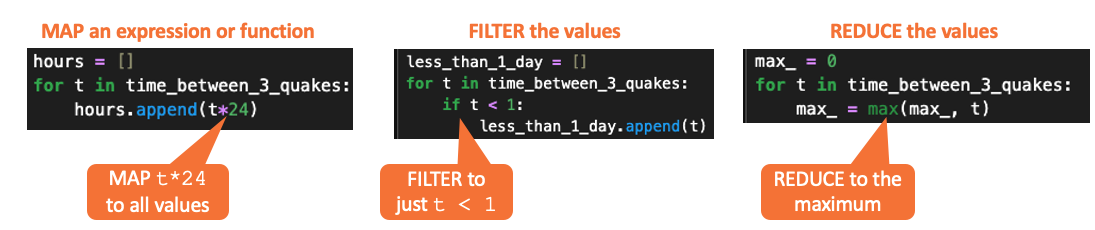

### All three patterns use the accumulator pattern

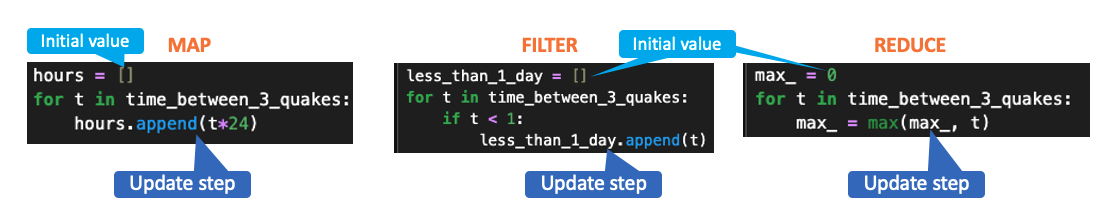

### Boilerplate code VS. What really matters.

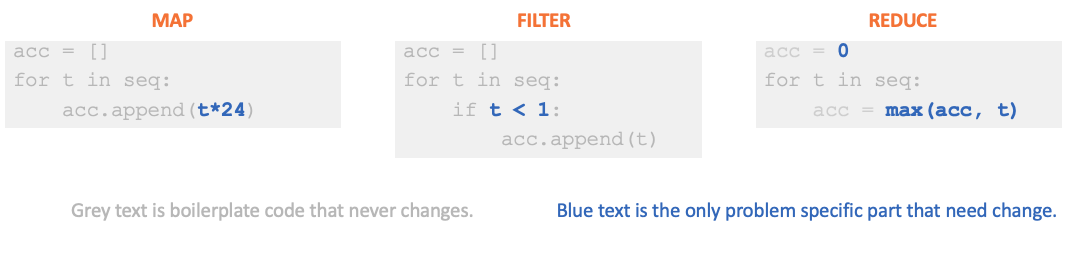

## Pattern 1 - MAP an expression or function

**Main points.** When mapping, 
1. `polars` is fastest,
2. `list` comprehension if not using `polars`,
3. `for` loops are the worst.

**Mapping Example.** Convert days $\longrightarrow$ hours.

#### Pure Python solutions

In [84]:
%%timeit -n 5 -r 3
# Loop solution
hours = []
for t in time_between_3_quakes:
    hours.append(t*24)

hours >> take(5)

4.35 s ± 232 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [85]:
%%timeit -n 5 -r 3
# Comprehension solution
([t*24
  for t in time_between_3_quakes
 ]
) >> take(5)

4.14 s ± 31.5 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [112]:
%%timeit -n 5 -r 3

# functional (lazy) solution
map(lambda t: 24*t, time_between_3_quakes)


4.14 s ± 12.9 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [86]:
import numpy as np

#### `numpy` is FAST!

In [94]:
%%timeit -n 5 -r 3

# Using map_elements
24*time_between_3_quakes_np

82.4 ms ± 5.53 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


#### `polars` is better!

In [88]:
%%timeit -n 5 -r 3

# Using map_elements
(time_between_3_quakes_pl
 .map_elements(lambda t: t*24)
).head(5)

<magic-timeit>:3: PolarsInefficientMapWarning: 
Series.map_elements is significantly slower than the native series API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - srs.map_elements(lambda t: ...)
with this one instead:
  + s * 24



6.8 s ± 19.3 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [89]:
%%timeit -n 5 -r 3

# Using an expressions
24*time_between_3_quakes_pl

80.1 ms ± 1.43 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [90]:
%%timeit -n 5 -r 3

# Inside a df
(pl.DataFrame({'time_between_3_quakes':time_between_3_quakes_pl})
   .with_columns(24*pl.col('time_between_3_quakes'))
)

81.5 ms ± 2.9 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


## Pattern 2 - Apply a FILTER

**Filter Example.**  Filter out all value less than 1 day.

In [114]:
%%timeit -n 5 -r 3

# loop solution
less_than_1_day = []
for t in time_between_3_quakes:
    if t < 1:
        less_than_1_day.append(t)
less_than_1_day >> take(5)

3.25 s ± 40.9 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [115]:
%%timeit -n 5 -r 3

# comprehension solution
([t 
  for t in time_between_3_quakes 
  if t < 1
 ]
) >> take(5)

3 s ± 7.82 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [116]:
%%timeit -n 5 -r 3

# functional (lazy) solution
filter(lambda t: t < 1, time_between_3_quakes)

3.12 s ± 6.33 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


#### `polars` is better!

In [117]:
%%timeit -n 5 -r 3

# polars Series

time_between_3_quakes_pl.filter(time_between_3_quakes_pl < 1)

98.8 ms ± 3.17 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [119]:
%%timeit -n 5 -r 3

(time_between_3_quakes_df
 .filter(pl.col('time_between_3_quakes') < 1)
)

108 ms ± 13.9 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


## Pattern 3 - REDUCE to a summary statistic

**Reduce example.** Computing the maximum

#### Option 1 - Set a reasonable initial value

In [104]:
%%timeit -n 5 -r 3

# Loop solution - Use a initial value of zero
max_time = 0 # safe since Gamma is non-negative
for t in time_between_3_quakes:
    max_time = max(max_time, t) # update step
max_time

6.4 s ± 13.3 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [105]:
%%timeit -n 5 -r 3

# functools.reduce
reduce(max, time_between_3_quakes, 0)

4.29 s ± 8.57 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [106]:
%%timeit -n 5 -r 3

# numpy array
time_between_3_quakes_np.max()

11.4 ms ± 254 μs per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [107]:
%%timeit -n 5 -r 3

# polars Series
time_between_3_quakes_pl.max()

11.3 ms ± 282 μs per loop (mean ± std. dev. of 3 runs, 5 loops each)


#### Option 2 - Use the first element as the initial value

This works because the `max(xs) >= xs[0]`

In [108]:
%%timeit -n 5 -r 3

## Loop solution - Use the first element as init
max_ = time_between_3_quakes[0]
for t in time_between_3_quakes[1:]:
    max_ = max(max_, t)
max_time

6.67 s ± 15.1 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [109]:
%%timeit -n 5 -r 3

## Calling reduce - Use the first value as init
reduce(max, time_between_3_quakes)

4.26 s ± 5.84 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


### <font color="red"> Exercise 3.0.5 </font>

Use the reduce pattern to compute the total time by

1. Use a `for` loop with an accumulator first, then
2. Refactor the code to use `reduce`, and finally
3. Discuss your (A) initial value and (B) update function and how they relate to the loop.

In [ ]:
# Your code here

<font color="orange">
    Your discussion here.
</font>